In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Add, Input, Activation, Multiply, Flatten, Reshape, Dot
from tensorflow.keras.models import Model
from tensorflow.keras import activations

In [2]:
DATA_PATH = os.path.join('..', 'data',)
KT1_PATH = os.path.join('..', 'data', 'KT1')

In [3]:
def get_correctness(user_df, questions_df):
    """
    Gets the correctness of the user's answer
    """
    merged_df = pd.merge(user_df, questions_df, on='question_id')
    correctness = np.float32(
        merged_df['user_answer'] == merged_df['correct_answer'])
    return correctness


def get_dataframe_extension(user_df, questions_df, keys=['tags'], user_id=None):
    """Merges user dataframe and question skills"""
    merged_df = pd.merge(
        user_df, questions_df[['question_id'] + keys], on='question_id')
    if user_id is not None:
        merged_df['user_id'] = [user_id] * merged_df.shape[0]
    return merged_df


def sorted_skill(skill):
    """Returns the string with sorted skills"""
    sorted_skill = sorted(map(lambda x: int(x), skill.split(';')))
    return ';'.join(map(lambda x: str(x), sorted_skill))


def save_some_tags(skill, tags_number=1):
    """Saves first tags_number skills"""
    return ';'.join(skill.split(';')[0:tags_number])


def get_sparse(skills, skills_num, norm=True):
    """
    Gets sparse representation of skills
    Args:
        skills (list): list with skill ids
        skills_num (int): number of skills (vector length)
        norm (bool): whether normalize vector or not (the vector is normalized such that it's components sum up to 1)
    """
    skills_list = np.array(skills) - 1
    skills_feature = np.eye(skills_num)[skills_list]
    skills_feature = skills_feature.sum(axis=0)
    if norm:
        return (skills_feature / (skills_feature.sum())).tolist()
    else:
        return skills_feature.tolist()


def flatten_skills(row):
    """
    Flattens the dataframe row into the array of rows according to the number of skills
    Args:
        row (pandas.Series): row with 'skill_name' key
    Returns:
        Array with rows. For example:
        >>> row = pd.Series(data={'question_id':'q1382', 'skill_name':'24;43;184;181', 'user_id':'u1', 'correct':1.0})
        >>> flatten_skills(row) 
        array([['q1382', '24', 'u1', 1.0],
            ['q1382', '43', 'u1', 1.0],
            ['q1382', '184', 'u1', 1.0],
            ['q1382', '181', 'u1', 1.0]], dtype=object)
    """
    skill_list = row['skill_name'].split(';')
    row_array = row.values
    flatten_array = np.tile(row.values, (len(skill_list), 1))
    skill_key_index = row.keys().tolist().index('skill_name')
    flatten_array[:, skill_key_index] = skill_list
    return flatten_array


def get_flatten_df(df):
    """Gets the dataframe with flatten skills"""
    flatten_df = df.apply(flatten_skills, axis=1)
    keys = df.keys()
    flatten_df = pd.DataFrame(np.concatenate(
        flatten_df.tolist()), columns=keys)
    return flatten_df

In [4]:
questions_df = pd.read_csv(os.path.join(KT1_PATH,'questions.csv'))
questions_df.tags

0             1;2;179;181
1                15;2;182
2            14;2;179;183
3             9;2;179;184
4             8;2;179;181
               ...       
13164       24;26;183;182
13165       24;33;183;182
13166       24;26;183;182
13167       24;26;183;182
13168    27;24;26;183;182
Name: tags, Length: 13169, dtype: object

In [5]:
import os
import glob
import numpy as np
import pandas as pd

# user_index = 1
# user_df, questions_df = pd.read_csv(f'u{user_index}.csv'),pd.read_csv('questions.csv')

questions_df = pd.read_csv(os.path.join(KT1_PATH,'questions.csv'))
questions_df = questions_df[questions_df.tags!='-1']

data_list, train_data_list, test_data_list =[], [], []

train_alpha = 1.0

# Unite each user's interaction data together
first_users_number = 1000
kt_users = glob.glob(os.path.join(KT1_PATH,'u*.csv'))[:first_users_number]
for user_fn in kt_users:
  user_df = pd.read_csv(user_fn)
  del user_df['timestamp']
  del user_df['elapsed_time']
  user_df = get_dataframe_extension(user_df, questions_df,  user_id=os.path.basename(user_fn).split('.')[0])
  user_df['correct'] = get_correctness(user_df, questions_df)
  del user_df['user_answer']
  del user_df['solving_id']
  # user_df['tags'] =  user_df['tags'].map(lambda skill: sorted_skill(skill))
  # user_df['tags'] =  user_df['tags'].map(lambda skill: sorted_skill(save_some_tags(skill)))
  # user_df['order_id'] = np.arange(0, user_df.shape[0])
  user_df = user_df.rename(columns={'tags': 'skill_name'})
  # data, test = user_df.iloc[:int(user_df.shape[0]*0.8)], user_df[int(user_df.shape[0]*0.8):]
  data = user_df
  train_data = user_df.iloc[:round(train_alpha*len(user_df))]
  test_data = user_df.iloc[round(train_alpha*len(user_df)):]
  train_data_list.append(train_data)
  data_list.append(data)
  test_data_list.append(test_data)

data = pd.concat(data_list)
data = data.reset_index(drop=True)
train_data, test_data  = pd.concat(train_data_list).reset_index(drop=True), pd.concat(test_data_list).reset_index(drop=True)
train_data

,question_id,skill_name,user_id,correct
0,q5012,74,u1,0.0
1,q5012,74,u1,0.0
2,q4706,71,u1,1.0
3,q4366,103,u1,1.0
4,q4829,83,u1,0.0
...,...,...,...,...
259967,q687,24;43;182;181,u100901,1.0
259968,q1338,28;37;184;181,u100901,0.0
259969,q888,34;35;182;181,u100901,0.0
259970,q256,34;42;184;183,u100901,1.0


In [6]:
def get_feature_description(df, norm = True, return_test_configs = True):
    """
    Creates feature description matrix from dataframe data
    """
    # TODO: make multiskill processing
    # Students encoding
    # codes, uniques = df['user_id'].factorize(sort=True)
    students, students_indices = df['user_id'].factorize(sort=True)
    students_indices = students_indices.to_list()
    students = pd.get_dummies(students).to_numpy()
    students_dict = {key: i for i, key in enumerate(students_indices)}
    
    skills, skills_indices = get_flatten_df(df)['skill_name'].apply(int).factorize(sort=True)
    skills_indices = list(map(str, skills_indices))
    skills_dict = {key: i for i, key in enumerate(skills_indices)}
    skills = df['skill_name'].str.split(';').apply(lambda x: [skills_dict[skill] for skill in x])

    skills = skills.apply(lambda x: get_sparse(x, len(skills_indices), norm))
    skills = pd.DataFrame(skills.to_list(), columns=skills_indices)

    opportunities = skills.groupby([df.user_id]).cumsum()
    skills = skills.to_numpy()
    opportunities = opportunities.to_numpy() * skills

    skills = df['skill_name'].str.split(';').apply(lambda x: [skills_dict[skill] for skill in x])
    skills = skills.apply(lambda x: get_sparse(x, len(skills_indices), norm = norm))
    skills = pd.DataFrame(skills.to_list(), columns=skills_indices)

    if return_test_configs:
        return students.astype(np.float32), skills.astype(np.float32), opportunities.astype(np.float32), (students_dict, skills_dict, students_indices, skills_indices)
    else:
        return students.astype(np.float32), skills.astype(np.float32), opportunities.astype(np.float32)

In [7]:
def get_split(dataset, split_size):
        split_set = dataset.take(split_size)
        dataset = dataset.skip(split_size)
        return dataset, split_set

def split_dataset(dataset, total_size, test_fraction, val_fraction=None):
    test_size = np.ceil(test_fraction * total_size)
    train_size = total_size - test_size

    train_set, test_set = get_split(dataset, test_size)

    val_set = None
    if val_fraction:
        val_size = np.ceil(train_size * val_fraction)
        train_set, val_set = get_split(train_set, val_size)

    return train_set, test_set, val_set

In [8]:
seed = 42
test_fraction = 0.2
val_fraction = 0.2
students, skills, opportunities, test_configs = get_feature_description(train_data)
sample_size = students.shape[0]
max_opportunities = opportunities.max().copy()
opportunities/=max_opportunities
y_true = np.expand_dims(train_data['correct'].to_numpy(), axis = -1)

students, skills, opportunities = tf.sparse.from_dense(students), tf.sparse.from_dense(skills), tf.sparse.from_dense(opportunities)

students_shape, skills_shape, opportunities_shape, y_true_shape = students.shape,skills.shape, opportunities.shape, y_true.shape
print(students.shape,skills.shape, opportunities.shape, y_true.shape)

dataset = tf.data.Dataset.from_tensor_slices(((students, skills, opportunities), y_true))
students_dataset = tf.data.Dataset.from_tensor_slices(students)
train_set, test_set, val_set = split_dataset(dataset.shuffle(sample_size, seed = seed), sample_size, test_fraction, val_fraction)

del students, skills, opportunities, y_true
del dataset

(259972, 1000) (259972, 187) (259972, 187) (259972, 1)


In [9]:
for batch in train_set:
    print(batch)
    break

((<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000017093D4FA08>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001709380D148>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000170938257C8>), <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


## Simple Factorization Machine

In [10]:
class SimpleFMClassifier(tf.keras.layers.Layer):
    """
    Simple FM
    """
    def __init__(self, features_num, k = 2):
        super().__init__()
        self.features_num = features_num
        self.k = k
    def build(self, input_shape):
        self.linear= Dense(1, input_shape = (self.features_num,), use_bias = True, name = 'linear')
        self.add = Add()
        self.v = self.add_weight(shape = (self.features_num, self.k),
                                initializer='random_normal',
                                trainable=True, name = 'vectors')
        self.activation = tf.keras.activations.sigmoid
    def call(self, X):
        out_linear = self.linear(X)
        out_1 = tf.reduce_sum(tf.square(tf.sparse.sparse_dense_matmul(X, self.v)), axis = 1, keepdims=True)
        out_2 = tf.reduce_sum(tf.sparse.sparse_dense_matmul(tf.square(X), tf.square(self.v)), axis=1, keepdims=True)
        out_multiplications = (out_1 - out_2)/2
        return self.activation(self.add([out_linear, out_multiplications]))

In [11]:
def get_simple_fm(shape, k):
    input = Input(shape = (shape,), sparse = True)
    fm_output = SimpleFMClassifier(shape, k)(input)
    simple_fm = tf.keras.models.Model(inputs = input, outputs = fm_output)
    optimizer = tf.optimizers.RMSprop()
    simple_fm.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=
            [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
            ]
    )
    return simple_fm

In [12]:
fm_train_set = train_set.map(lambda features, labels: (tf.sparse.concat(0, list(features)), labels))
fm_test_set = test_set.map(lambda features, labels: (tf.sparse.concat(0, list(features)), labels))
fm_val_set = val_set.map(lambda features, labels: (tf.sparse.concat(0, list(features)), labels))

In [13]:
for batch in fm_train_set:
    print(batch)
    break

(<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000170FFE510C8>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)


In [14]:
epochs = 100
batch_size = 4096*8
shape = students_shape[-1] + 2* skills_shape[-1]
k_params = [2,5,10]

simple_fm_models = dict()
for k in k_params:
    print(k)
    simple_fm = get_simple_fm(shape, k)
    simple_fm_models[k] = {'model': simple_fm}
    simple_fm_history = simple_fm.fit(fm_train_set.batch(batch_size), epochs = epochs, validation_data = fm_val_set.batch(4096), verbose = 0)
    simple_fm_models[k]['history'] = simple_fm_history

2


c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/simple_fm_classifier/linear/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/simple_fm_classifier/linear/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model/simple_fm_classifier/linear/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


5


c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/simple_fm_classifier_1/linear/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/simple_fm_classifier_1/linear/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/simple_fm_classifier_1/linear/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


10


c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/simple_fm_classifier_2/linear/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/simple_fm_classifier_2/linear/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/simple_fm_classifier_2/linear/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


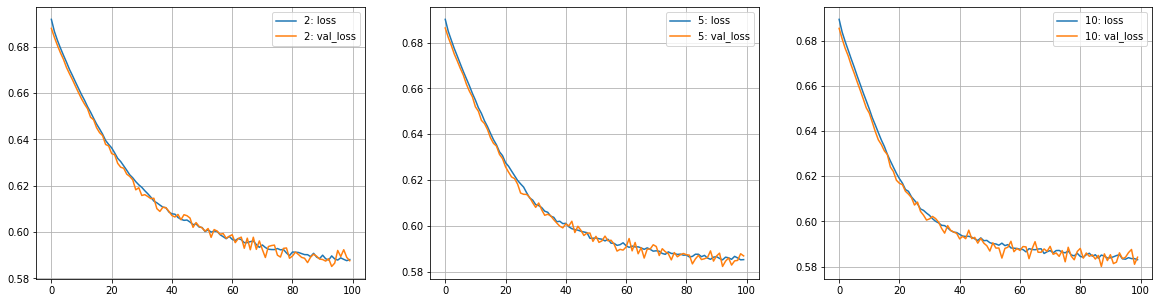

In [15]:
import matplotlib.pyplot as plt
# Multiskill
plt.figure(figsize=[20, 5])
for i,k in enumerate(k_params):
    plt.subplot(1,len(k_params), i+1)
    history = simple_fm_models[k]['history']
    epochs = history.epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, label = f'{k}: loss')
    plt.plot(epochs, val_loss, label = f'{k}: val_loss')
    plt.legend()
    plt.grid()
plt.show()

In [16]:
for i, k in enumerate(k_params):
    print(f'{k}:')
    print(simple_fm_models[k]['model'].evaluate(fm_test_set.batch(4096)))

2:
13/13 [==============================] - 2s 74ms/step - loss: 0.5868 - binary_accuracy: 0.7024 - precision: 0.7065 - recall: 0.9577 - auc: 0.6704
[0.5867606997489929, 0.7023944854736328, 0.7064982652664185, 0.9577324390411377, 0.6703505516052246]
5:
13/13 [==============================] - 2s 68ms/step - loss: 0.5861 - binary_accuracy: 0.7017 - precision_1: 0.7066 - recall_1: 0.9531 - auc_1: 0.6731
[0.5860610008239746, 0.7016828656196594, 0.7066003680229187, 0.953143298625946, 0.673107385635376]
10:
13/13 [==============================] - 2s 72ms/step - loss: 0.5800 - binary_accuracy: 0.7075 - precision_2: 0.7130 - recall_2: 0.9520 - auc_2: 0.6776
[0.5799511671066284, 0.7074910998344421, 0.7130026817321777, 0.9520313143730164, 0.677561342716217]


## Special FM

In [30]:
class SpecialFMClassifier(tf.keras.layers.Layer):
    """
    Special FM version
    """
    def __init__(self, students_num, skills_num, k = 2):
        super().__init__()
        self.students_num = students_num
        self.skills_num = skills_num
        # self.opportunities = opportunities
        self.k = k

    def build(self, input_shape):
        self.linear_students = Dense(1, input_shape = (self.students_num,), use_bias = False, name = 'students')
        self.linear_skills = Dense(1, input_shape = (self.skills_num,), use_bias = False, name = 'skills')
        self.linear_interactions = Dense(1, input_shape = (self.skills_num,), use_bias = False, name = 'interactions')
        self.add = Add()
        self.v = self.add_weight(shape = (self.skills_num, self.k),
                                initializer='random_normal',
                                trainable=True, name = 'vectors')
        self.activation = tf.keras.activations.sigmoid
    def call(self, X):
        students, skills, interactions = X[0], X[1], X[2]
        out_students = self.linear_students(students)
        out_skills = self.linear_skills(skills)
        out_interactions = self.linear_interactions(interactions)
        out_1 = tf.reduce_sum(tf.square(tf.sparse.sparse_dense_matmul(interactions, self.v)), axis = 1, keepdims=True)
        out_2 = tf.reduce_sum(tf.sparse.sparse_dense_matmul(tf.square(interactions), tf.square(self.v)), axis=1, keepdims=True)
        out_multiplications = (out_1 - out_2)/2
        return self.activation(self.add([out_students, out_skills, out_interactions, out_multiplications]))

In [31]:
def get_special_fm(alpha_shape, beta_shape, k):
    input1, input2, input3 = Input(shape = (alpha_shape,), sparse=True), Input(shape = (beta_shape,), sparse=True), Input(shape = (beta_shape,), sparse=True)
    # fm = FMClassifier(alpha_shape, beta_shape)
    fm_output = SpecialFMClassifier(alpha_shape, beta_shape, k=10)([input1, input2, input3])
    fm = tf.keras.models.Model(inputs = [input1, input2, input3], outputs = fm_output)
    optimizer = tf.optimizers.RMSprop()
    fm.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=
            [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
            ]
    )
    return fm

In [32]:
alpha_shape, beta_shape = students_shape[-1], skills_shape[-1]
epochs = 100
batch_size = 4096*8

k_params = [2,5,10]
special_fm_models = dict()
for k in k_params:
    special_fm = get_special_fm(alpha_shape, beta_shape, k)
    special_fm_models[k] = {'model': special_fm}
    # special_fm_history = special_fm.fit([students, skills, interactions], y_true, batch_size = batch_size, epochs = epochs, verbose = 0)
    special_fm_history = special_fm.fit(train_set.batch(batch_size), epochs = epochs, validation_data = val_set.batch(4096), verbose = 0)
    special_fm_models[k]['history'] = special_fm_history

c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/special_fm_classifier/interactions/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_10/special_fm_classifier/interactions/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_10/special_fm_classifier/interactions/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/special_fm_classifier/students/embedding_lookup_sparse/R

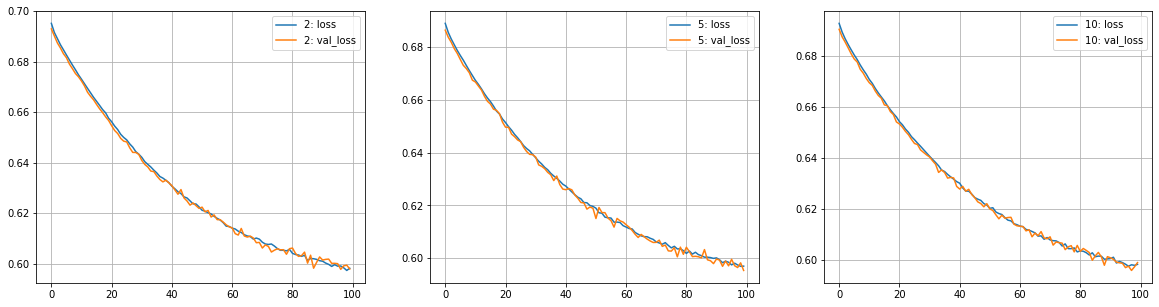

In [33]:
import matplotlib.pyplot as plt
# Interactions
plt.figure(figsize=[20, 5])
for i,k in enumerate(k_params):
    plt.subplot(1,len(k_params), i+1)
    history = special_fm_models[k]['history']
    epochs = history.epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, label = f'{k}: loss')
    plt.plot(epochs, val_loss, label = f'{k}: val_loss')
    plt.legend()
    plt.grid()
plt.show()

In [34]:
for i, k in enumerate(k_params):
    print(f'{k}:')
    print(special_fm_models[k]['model'].evaluate(test_set.batch(4096)))

2:
13/13 [==============================] - 2s 73ms/step - loss: 0.5988 - binary_accuracy: 0.6944 - precision_10: 0.6944 - recall_10: 0.9755 - auc_10: 0.6590
[0.598760187625885, 0.6944129467010498, 0.6943800449371338, 0.975492000579834, 0.6590436697006226]
5:
13/13 [==============================] - 2s 72ms/step - loss: 0.5978 - binary_accuracy: 0.6960 - precision_11: 0.6967 - recall_11: 0.9746 - auc_11: 0.6545
[0.5977691411972046, 0.696028470993042, 0.6967213153839111, 0.9745654463768005, 0.6545010209083557]
10:
13/13 [==============================] - 2s 68ms/step - loss: 0.5981 - binary_accuracy: 0.6955 - precision_12: 0.6961 - recall_12: 0.9745 - auc_12: 0.6573
[0.5980575680732727, 0.6955091953277588, 0.6960936188697815, 0.974507212638855, 0.657275378704071]


## LFA

In [ ]:
def get_lfa(alpha_shape, beta_shape, sparse = True):
    input1, input2, input3 = Input(shape = (alpha_shape,), sparse = True), Input(shape = (beta_shape,), sparse = True), Input(shape = (beta_shape,), sparse = True)
    students = Dense(1, use_bias = False)
    skills = Dense(1, use_bias = False)
    interactions = Dense(1, use_bias = False)
    activation = Activation(activations.sigmoid)
    add = Add()
    output = add([students(input1), skills(input2), interactions(input3)])
    output = activation(output)
    model = Model(inputs = [input1, input2, input3], outputs = output)
    # print(interactions_input1.shape, interactions_input2.shape,flatten(dot))
    return model

In [ ]:
alpha_shape, beta_shape = students_shape[-1], skills_shape[-1]
lfa = get_lfa(alpha_shape, beta_shape)
# optimizer = tf.optimizers.SGD()
optimizer = tf.optimizers.RMSprop()
lfa.compile(
    optimizer = optimizer,
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    loss = 'binary_crossentropy',
    metrics=
        [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
        ]
)
lfa.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 187)]        0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 187)]        0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 1)            1000        ['input_28[0][0]']               
                                                                                            

In [ ]:
epochs = 100
batch_size = 4096*10
lfa_history = lfa.fit(train_set.batch(batch_size), epochs = epochs, validation_data=val_set.batch(4096), verbose=0)

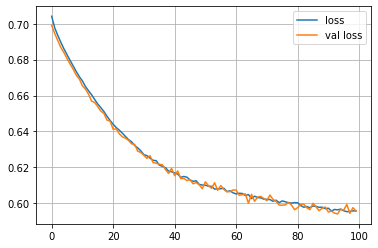

In [139]:
import matplotlib.pyplot as plt
# Multiskill
epochs = lfa_history.epoch
loss = lfa_history.history['loss']
val_loss = lfa_history.history['val_loss']
plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'val loss')
plt.legend()
plt.grid()
plt.show()

In [136]:
lfa.evaluate(test_set.batch(4096))

13/13 [==============================] - 3s 106ms/step - loss: 0.5964 - binary_accuracy: 0.6938 - precision_9: 0.6957 - recall_9: 0.9687 - auc_9: 0.6566


[0.5964477062225342,
 0.693835973739624,
 0.6957101821899414,
 0.968733012676239,
 0.6566184163093567]

## Logistic regression

In [172]:
for batch in train_set.batch(4):
    print(batch[0])
    print(list(batch[0]))
    print(type(batch[0]))
    # print(tf.sparse.concat(1, list(batch[0])))
    print(type(tf.sparse.concat(1, list(batch[0]))))
    break

(<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF3992D88>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF3975388>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF39CFDC8>)
[<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF3992D88>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF3975388>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000014DF39CFDC8>]
<class 'tuple'>
<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


In [37]:
lr_train_set = train_set.map(lambda features, labels: (tf.sparse.concat(0, list(features[:2])), labels))
lr_test_set = test_set.map(lambda features, labels: (tf.sparse.concat(0, list(features[:2])), labels))
lr_val_set = val_set.map(lambda features, labels: (tf.sparse.concat(0, list(features[:2])), labels))

In [182]:
input = Input(shape = (students_shape[-1]+skills_shape[-1]), sparse=True)
linear = Dense(1)
output = activations.sigmoid(linear(input))
lr_model = Model(inputs = input, outputs = output)
optimizer = tf.optimizers.RMSprop()
lr_model.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=
            [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
            ]
    )
lr_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 1187)]            0         
                                                                 
 dense_32 (Dense)            (None, 1)                 1188      
                                                                 
 tf.math.sigmoid_2 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 1,188
Trainable params: 1,188
Non-trainable params: 0
_________________________________________________________________


In [183]:
epochs = 100
batch_size = 4096*10
lr_history = lr_model.fit(lr_train_set.batch(batch_size), epochs = epochs, validation_data=lr_val_set.batch(4096), verbose = 0)

c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_12/dense_32/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_12/dense_32/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_12/dense_32/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


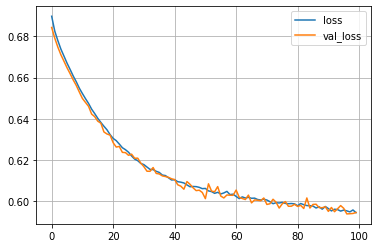

In [185]:
import matplotlib.pyplot as plt
# Multiskill
epochs = lr_history.epoch
loss = lr_history.history['loss']
val_loss = lr_history.history['val_loss']
plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.legend()
plt.grid()
plt.show()

In [186]:
lr_model.evaluate(lr_test_set.batch(4096))

13/13 [==============================] - 2s 81ms/step - loss: 0.5953 - binary_accuracy: 0.6931 - precision_12: 0.6941 - recall_12: 0.9749 - auc_12: 0.6590


[0.5953290462493896,
 0.6931435465812683,
 0.6940887570381165,
 0.9749173521995544,
 0.6589823365211487]

## FM with students и skills

In [35]:
def get_simple_fm(shape, k):
    input = Input(shape = (shape,), sparse = True)
    fm_output = SimpleFMClassifier(shape, k)(input)
    simple_fm = tf.keras.models.Model(inputs = input, outputs = fm_output)
    optimizer = tf.optimizers.RMSprop()
    simple_fm.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=
            [
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
            ]
    )
    return simple_fm

In [38]:
# import multiprocessing
# import pickle
epochs = 100
batch_size = 4096*10
shape = students_shape[-1] + skills_shape[-1]
k_params = [2,5,10]
two_fm_models = dict()
for k in k_params:
    two_fm = get_simple_fm(shape, k)
    two_fm_models[k] = {'model': two_fm}
    two_fm_history = two_fm.fit(lr_train_set.batch(batch_size), epochs = epochs, validation_data = lr_val_set.batch(4096), verbose = 0)
    two_fm_models[k]['history'] = two_fm_history

c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_14/simple_fm_classifier_11/linear/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_14/simple_fm_classifier_11/linear/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_14/simple_fm_classifier_11/linear/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
c:\Users\globalpie\Projects\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_15/simple_fm_classifier_12/linear/embedding_lookup_sparse/Reshape_1:0",

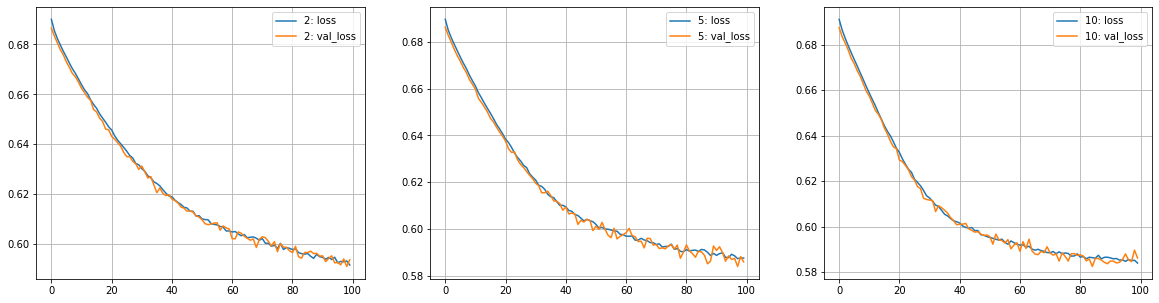

In [39]:
import matplotlib.pyplot as plt
# Multiskill
plt.figure(figsize=[20, 5])
for i,k in enumerate(k_params):
    plt.subplot(1,len(k_params), i+1)
    history = two_fm_models[k]['history']
    epochs = history.epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, label = f'{k}: loss')
    plt.plot(epochs, val_loss, label = f'{k}: val_loss')
    plt.legend()
    plt.grid()
plt.show()

In [40]:
for i, k in enumerate(k_params):
    print(f'{k}:')
    print(two_fm_models[k]['model'].evaluate(lr_test_set.batch(4096)))

2:
13/13 [==============================] - 2s 74ms/step - loss: 0.5937 - binary_accuracy: 0.6955 - precision_14: 0.6956 - recall_14: 0.9734 - auc_14: 0.6685
[0.5936562418937683, 0.6955476403236389, 0.6955846548080444, 0.973380982875824, 0.6684637069702148]
5:
13/13 [==============================] - 2s 73ms/step - loss: 0.5877 - binary_accuracy: 0.7021 - precision_15: 0.7064 - recall_15: 0.9566 - auc_15: 0.6695
[0.5876737236976624, 0.7020867466926575, 0.7064449787139893, 0.9565922617912292, 0.6694678664207458]
10:
13/13 [==============================] - 2s 73ms/step - loss: 0.5874 - binary_accuracy: 0.7004 - precision_16: 0.7055 - recall_16: 0.9529 - auc_16: 0.6709
[0.5873655676841736, 0.7003750205039978, 0.7054905891418457, 0.9529099464416504, 0.6709358096122742]
